In [108]:
from unemployment import *
from unemployment import evaluate_model, plot_predictions, display_metrics_table

In [109]:
from pygam import LinearGAM, s

In [110]:
file_path = "fredupdated.csv"
df = pd.read_csv(file_path, parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)

# Filter data starting from 1959
start_date = '1959-01-01'
df = df.loc[start_date:].reset_index()

# Calculate inflation rate (year-over-year percent change in CPI)
df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100
df.drop(columns=['CPIAUCSL'], inplace=True)

# Handle missing values
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Feature Engineering - Create first difference of unemployment rate
df['UNRATE_Diff1'] = df['UNRATE'].diff()

# Create lag features for key variables
lag_features = ['UNRATE', 'GDP', 'FEDFUNDS', 'GS10', 'Inflation_Rate']
lags = [1, 4]  # 1-quarter and 4-quarter lags

for col in lag_features:
    for lag in lags:
        df[f'{col}_Lag{lag}Q'] = df[col].shift(lag)

# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

# Create a copy of the original dataframe for the original visualizations
df_original = df.copy()

# Feature Selection (based on multicollinearity)
# First round of dropping high-VIF features
drop_cols_1 = [
    'GDP',     # Keep GDPC1 instead
    'PCE',     # Redundant with GDP
    'M2SL',    # Redundant with GDP
    'PPIACO',  # Redundant with GDP
    'GS10',    # Keep FEDFUNDS instead
]
df = df.drop(columns=drop_cols_1, errors='ignore')

# Second round of dropping high-VIF features
drop_cols_2 = [
    'GDP_Lag1Q', 'GDP_Lag4Q',  # GDP lags too collinear, keeping GDPC1 instead
    'Inflation_Rate_Lag1Q',    # Drop due to high correlation with Inflation_Rate
    'GS10_Lag1Q',              # Drop short-term, keep GS10_Lag4Q (long-term rates)
    'FEDFUNDS_Lag1Q'           # Drop, keeping FEDFUNDS
]
df = df.drop(columns=drop_cols_2, errors='ignore')

# Third round of dropping high-VIF features
drop_cols_3 = [
    'CIVPART',              # Too correlated with UNRATE
    # 'UNRATE_Lag4Q',         # Redundant with UNRATE_Lag1Q
    'GS10_Lag4Q',           # High VIF, FEDFUNDS already captures monetary policy
    'Inflation_Rate_Lag4Q'  # High VIF, keeping Inflation_Rate instead
]
df = df.drop(columns=drop_cols_3, errors='ignore')

# Define the final set of features for modeling (similar to the notebook)
final_predictors = [
    'FEDFUNDS', 
    'GDPC1', 
    'Inflation_Rate', 
    'UNRATE_Diff1', 
    # 'UNRATE_Lag1Q', 
    'UNRATE_Lag4Q',
    'FEDFUNDS_Lag4Q'
]

# Keep a copy of the transformed dataframe for modeling
df_model = df.copy()

/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_11682/1965544404.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100
/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_11682/1965544404.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_11682/1965544404.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# Visualization
- We visualize:
    - Quarterly unemployment rate in the US from 1948 to 2025.
    - 10 year rolling mean of the unemployment rate.
    - Unemployment vs Inflation philips curve.

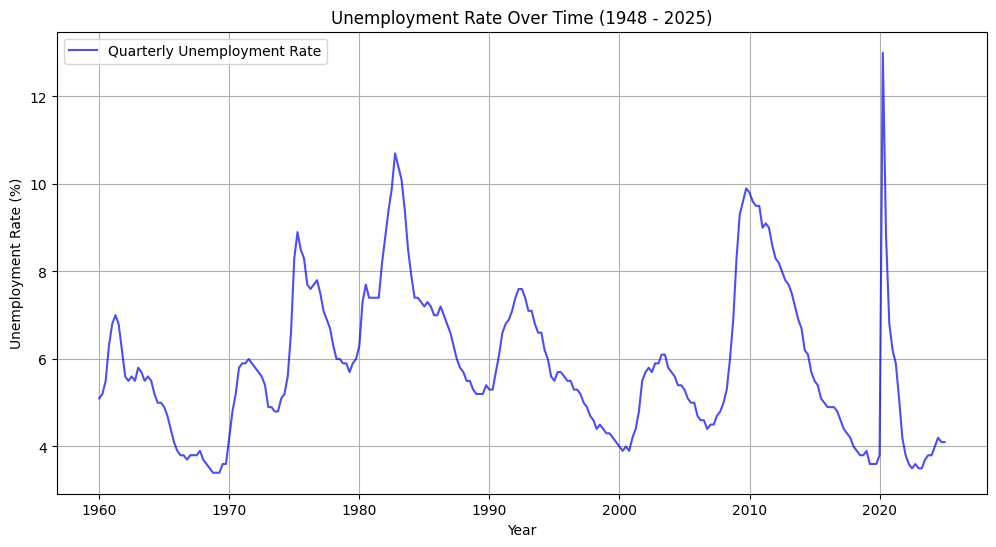

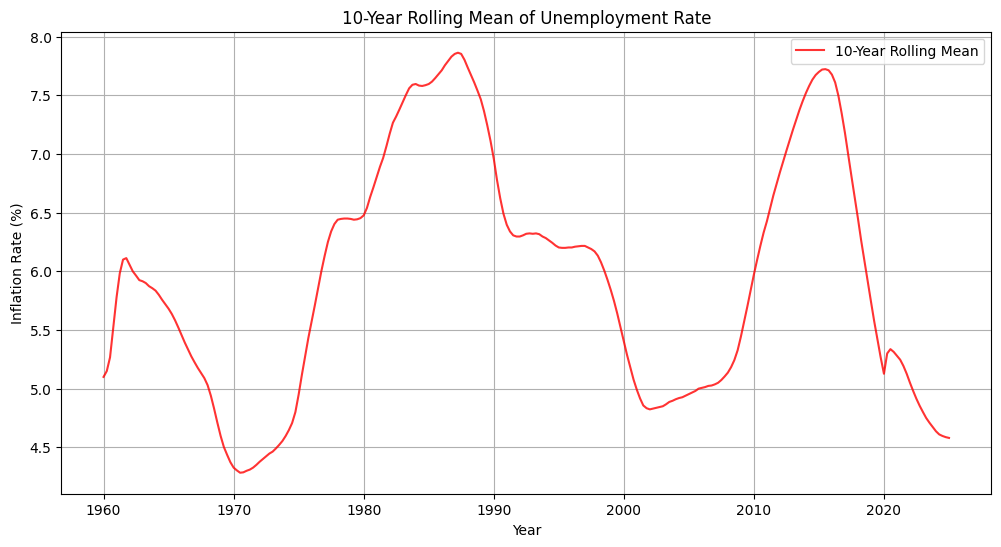

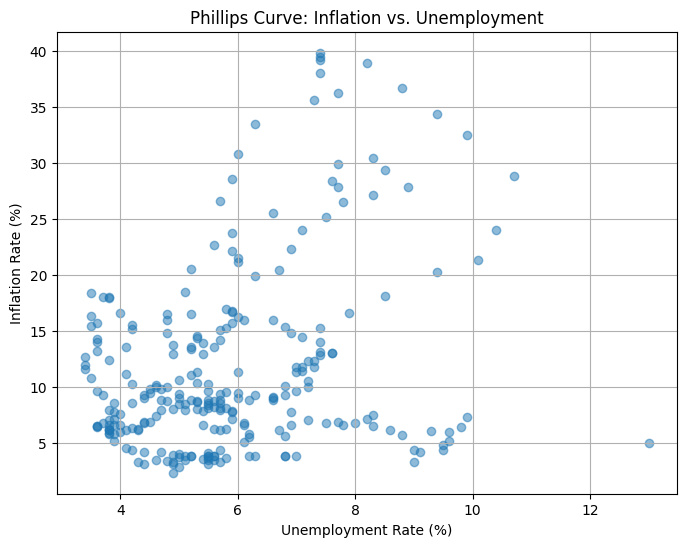

In [111]:
# Time Series Plot: Monthly Inflation Rate
plt.figure(figsize=(12, 6))
plt.plot(df_original['observation_date'], df_original['UNRATE'], label='Quarterly Unemployment Rate', color='blue', alpha=0.7)
plt.title("Unemployment Rate Over Time (1948 - 2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# 10-Year (120 months -> 30 quarters) Rolling Mean of Inflation Rate
df['Rolling_UNRATE'] = df['UNRATE'].rolling(window=30, min_periods=1).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['observation_date'], df['Rolling_UNRATE'], label='10-Year Rolling Mean', color='red', alpha=0.8)
plt.title("10-Year Rolling Mean of Unemployment Rate")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Inflation vs. Unemployment (Phillips Curve)
plt.figure(figsize=(8, 6))
plt.scatter(df_model['UNRATE'], df_model['Inflation_Rate'], alpha=0.5)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Inflation Rate (%)")
plt.title("Phillips Curve: Inflation vs. Unemployment")
plt.grid(True)
plt.show()

In [112]:
# Target = unemployment rate
# Predictor = inflation rate
X = df_model[final_predictors].values
y = df_model['UNRATE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [113]:
unemployment_data = df_model['UNRATE']
dates = df_model['observation_date']

In [114]:
# FOR ARIMA
train_data = pd.Series(y_train)
test_data = pd.Series(y_test)

In [115]:
train_size = len(train_data)
train_dates = dates[:train_size]
test_dates = dates[train_size:]

In [116]:
# 4: ARIMA with Standard Parameters
# Fit ARIMA model (p=1, d=1, q=1) - standard parameters for economic data
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -15.225
Date:                Mon, 10 Mar 2025   AIC                             36.449
Time:                        20:14:52   BIC                             46.448
Sample:                             0   HQIC                            40.493
                                - 208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5992      0.058     10.365      0.000       0.486       0.713
ma.L1          0.0877      0.085      1.032      0.302      -0.079       0.254
sigma2         0.0676      0.005     13.160      0.000       0.058       0.078
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.28
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.56
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
train_predictions = model_fit.predict(start=0, end=len(train_data)-1)
test_predictions = model_fit.forecast(steps=len(test_data))

train_metrics = evaluate_model(train_data, train_predictions, "Training")
test_metrics = evaluate_model(test_data, test_predictions, "Test")

In [118]:
display_metrics_table(train_metrics, test_metrics, model_name="ARIMA(1,1,1)")


Model Evaluation: ARIMA(1,1,1)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.1924                10.7241
RMSE            0.4386                3.2748
MAE             0.2146                2.9395
R^2             0.9250                -2.1004
Accuracy        0.9274                0.3745
Accuracy (%)    92.74%              37.45%
------------------------------------------------------------


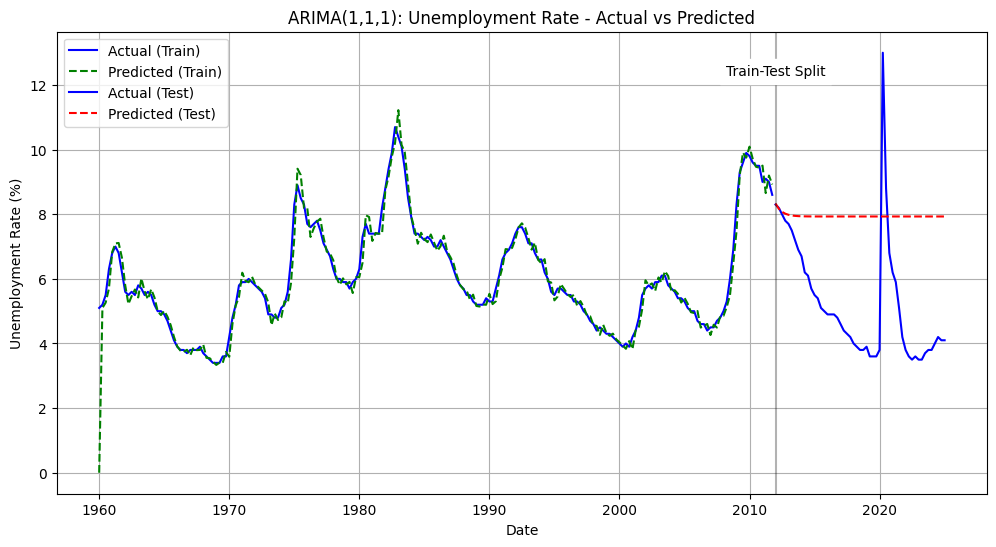

In [119]:
plot_predictions(
    train_data, train_predictions, 
    test_data, test_predictions,
    train_dates, test_dates, 
    model_name="ARIMA(1,1,1)"
)


Model Evaluation: Random Forest
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.0450                3.6601
RMSE            0.2122                1.9131
MAE             0.1418                1.6131
R^2             0.9824                -0.0582
Accuracy        0.9649                0.6346
Accuracy (%)    96.49%              63.46%
------------------------------------------------------------


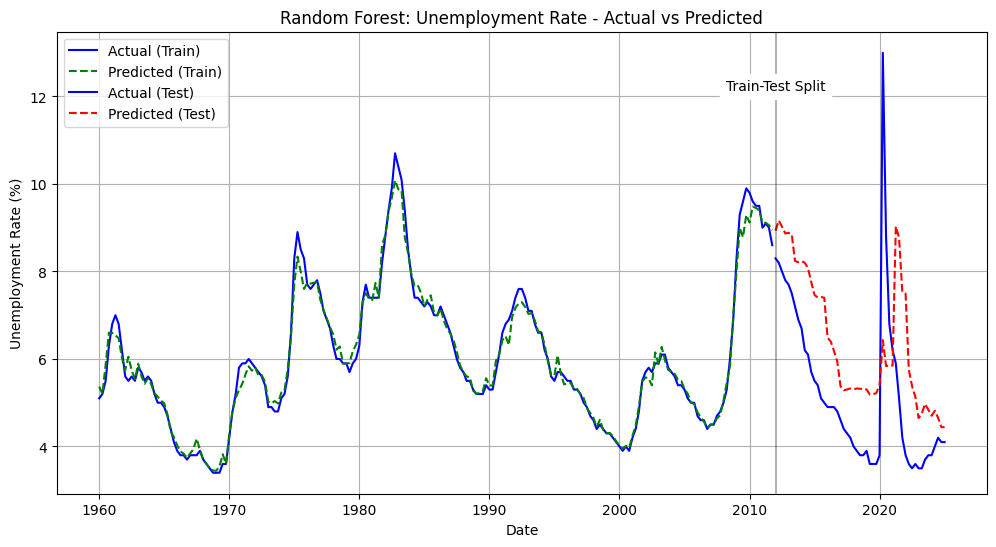

In [120]:
# 5: Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name="Random Forest")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name="Random Forest"
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best k value: 11
Training KNN Regression model with k=11...

Model Evaluation: KNN (k=11)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.4487                2.3398
RMSE            0.6699                1.5296
MAE             0.4198                1.2782
R^2             0.8251                0.3235
Accuracy        0.8891                0.7079
Accuracy (%)    88.91%              70.79%
------------------------------------------------------------


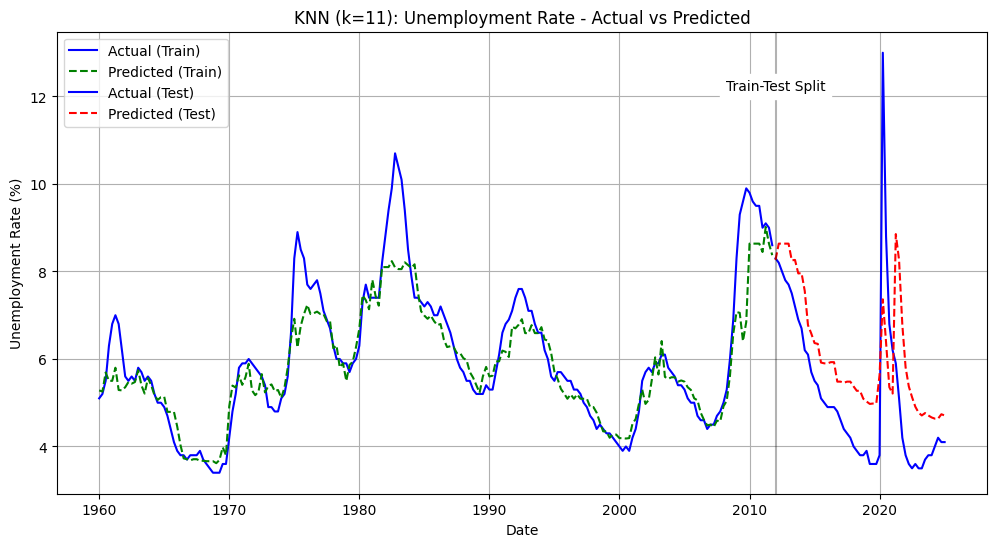

In [121]:
# 6: k-Nearest Neighbors Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# optimal k using cross-validation
param_grid = {'n_neighbors': range(1, 30, 2)}
grid_search = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

print(f"Training KNN Regression model with k={best_k}...")
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

train_predictions = knn_model.predict(X_train_scaled)
test_predictions = knn_model.predict(X_test_scaled)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name=f"KNN (k={best_k})")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name=f"KNN (k={best_k})"
)

In [122]:
# 7: GAM with Spline Terms 
# have to use scikit cause pygam has issues with numpy's new release
feature_models = []
feature_predictions_train = []
feature_predictions_test = []

for i, feature_name in enumerate(final_predictors):
    spline = make_pipeline(
        SplineTransformer(n_knots=5, degree=3),
        LinearRegression()
    )
    
    spline.fit(X_train_scaled[:, i:i+1], y_train)
    
    pred_train = spline.predict(X_train_scaled[:, i:i+1])
    pred_test = spline.predict(X_test_scaled[:, i:i+1])
    
    feature_models.append(spline)
    feature_predictions_train.append(pred_train)
    feature_predictions_test.append(pred_test)


Model Evaluation: GAM (scikit-learn)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             1.1114                5.0608
RMSE            1.0542                2.2496
MAE             0.8416                1.9778
R^2             0.5668                -0.4631
Accuracy        0.8255                0.5703
Accuracy (%)    82.55%              57.03%
------------------------------------------------------------


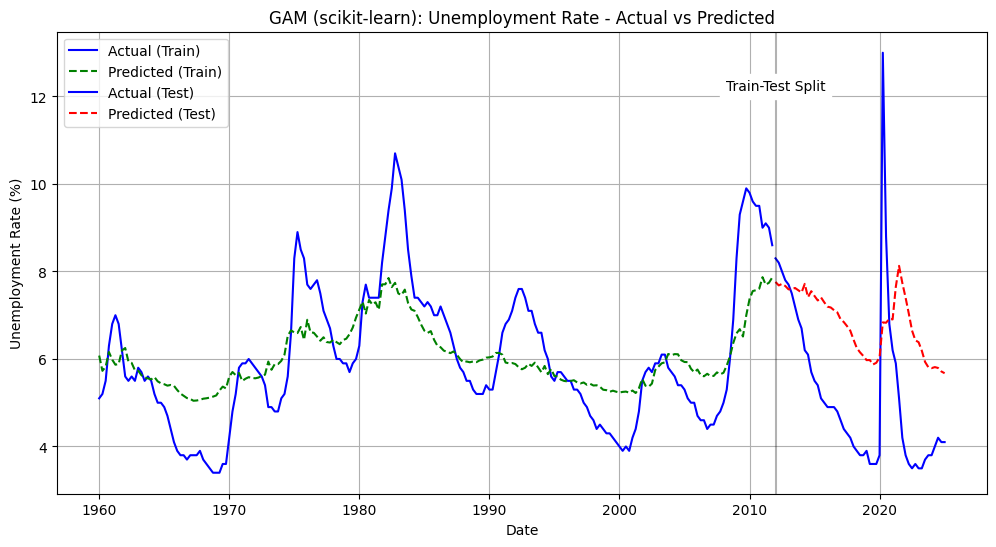

In [123]:
train_predictions = np.mean(feature_predictions_train, axis=0)
test_predictions = np.mean(feature_predictions_test, axis=0)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name="GAM (scikit-learn)")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name="GAM (scikit-learn)"
)